In [16]:
import argparse
import os
import os.path as osp
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import rich.progress as progress
import torch
import torch.nn.functional as F
from mmengine.config import Config, DictAction
from mmengine.device import get_device
from mmengine.logging import MMLogger
from mmengine.runner import Runner
from mmengine.utils import mkdir_or_exist

from mmpretrain.apis import get_model
from mmpretrain.registry import DATASETS

try:
    from sklearn.manifold import TSNE
except ImportError as e:
    raise ImportError('Please install `sklearn` to calculate '
                      'TSNE by `pip install scikit-learn`') from e

In [17]:
work_dir = 'work_dir'
# create work_dir
timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
tsne_work_dir = osp.join(work_dir, f'tsne_{timestamp}/')
mkdir_or_exist(osp.abspath(tsne_work_dir))

In [18]:
import pcl.loader
import pcl.builder
import torchvision.models as models

# create model
arch = "resnet50"
low_dim = 128
pcl_r = 32
moco_m = 0.999
temperature = 0.2
mlp = True
print("=> creating model '{}'".format(arch))
model = pcl.builder.MoCo(models.__dict__[arch], low_dim, pcl_r, moco_m, temperature, mlp)
# print(model)
model = model.cuda()

=> creating model 'resnet50'


In [19]:
# load model
resume = 'experiment_pcl2/checkpoint_0139.pth.tar'
print("=> loading checkpoint '{}'".format(resume))
loc = 'cuda:{}'.format(0)
checkpoint = torch.load(resume, map_location=loc)
# 去掉'module'前缀
state_dict = checkpoint['state_dict']
new_state_dict = {}
for k, v in state_dict.items():
    name = k[7:] if k.startswith('module.') else k  # 去掉 'module.' 前缀
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)

=> loading checkpoint 'experiment_pcl2/checkpoint_0139.pth.tar'


<All keys matched successfully>

In [37]:
# build the dataset
dataset_type = 'HgDataset'

test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='ResizeEdge', scale=256, edge='short'),
    dict(type='CenterCrop', crop_size=224),
    dict(type='PackInputs'),
]

val_dataloader = dict(
    batch_size=32,
    num_workers=5,
    dataset=dict(
        type=dataset_type,
        data_root='/home/siyi/DefectDetection/CL_for_Real/mmpretrain/data/hg',
        split='val',
        pipeline=test_pipeline),
    sampler=dict(type='DefaultSampler', shuffle=False),
)
test_dataloader = val_dataloader
dataloader_cfg = val_dataloader

In [38]:
dataset = DATASETS.build(dataloader_cfg.pop('dataset'))
classes = ('crack', 'hole', 'normal', 'object', 'wrinkle')

self.ann_file 
self.with_label True
{'crack': 0, 'hole': 1, 'normal': 2, 'object': 3, 'wrinkle': 4}
('normal', 'object', 'crack', 'hole', 'wrinkle')


In [22]:
num_classes = len(classes)
class_idx = list(range(num_classes))

In [23]:
# compress dataset, select that the label is less then max_num_class
subset_idx_list = []
counter = defaultdict(int)
for i in range(len(dataset)):
    gt_label = dataset.get_data_info(i)['gt_label']
    if (gt_label in class_idx):
            subset_idx_list.append(i)
            counter[gt_label] += 1

dataset.get_subset_(subset_idx_list)
print(f'Apply t-SNE to visualize {len(subset_idx_list)} samples.')

Apply t-SNE to visualize 278 samples.


In [24]:
dataloader_cfg['dataset'] = dataset
dataloader_cfg.setdefault('collate_fn', dict(type='default_collate'))
dataloader = Runner.build_dataloader(dataloader_cfg)

In [25]:
import torch
from torchvision import transforms
from rich.progress import track

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
eval_augmentation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [26]:
results = dict()
features = []
labels = []

for data in progress.track(dataloader, description='Calculating...'):
    with torch.no_grad():
        # preprocess data
        # 数据预处理
        batch_inputs = data['inputs']
        batch_inputs_augmented = []
        for img in batch_inputs:
            img_cpu = img.cpu()  # 将图像从 GPU 转移到 CPU
            img_pil = transforms.ToPILImage()(img_cpu)  # 转换为 PIL 图像
            img_augmented = eval_augmentation(img_pil)  # 执行数据增强
            batch_inputs_augmented.append(img_augmented)  # 将增强后的图像添加到列表中
        batch_inputs = torch.stack(batch_inputs_augmented).cuda()
        batch_data_samples = data['data_samples']
        batch_labels = torch.cat([i.gt_label for i in batch_data_samples])
                
        # extract backbone features
        extract_args = {}
        
        batch_features = (model.get_feature(batch_inputs), )
        # post process
        if batch_features[0].ndim == 4:
            # For (N, C, H, W) feature
            batch_features = [
                F.adaptive_avg_pool2d(inputs, 1).squeeze()
                for inputs in batch_features
            ]
        elif batch_features[0].ndim == 3:
            # For (N, L, C) feature
            batch_features = [inputs.mean(1) for inputs in batch_features]

    # save batch features
    features.append(batch_features)
    labels.extend(batch_labels.cpu().numpy())

Output()

In [27]:
for i in range(len(features[0])):
    key = 'feat_' + str(3)
    results[key] = np.concatenate(
        [batch[i].cpu().numpy() for batch in features], axis=0)

In [28]:
# save features
for key, val in results.items():
    output_file = f'{tsne_work_dir}{key}.npy'
    np.save(output_file, val)

In [29]:
n_components = 2
perplexity = 30.0
early_exaggeration = 12.0
learning_rate = 200.0
n_iter = 1000
n_iter_without_progress = 300
init = 'random'
legend = True
show = True

# build t-SNE model
tsne_model = TSNE(
    n_components=n_components,
    perplexity=perplexity,
    early_exaggeration=early_exaggeration,
    learning_rate=learning_rate,
    n_iter=n_iter,
    n_iter_without_progress=n_iter_without_progress,
    init=init)

Running t-SNE.


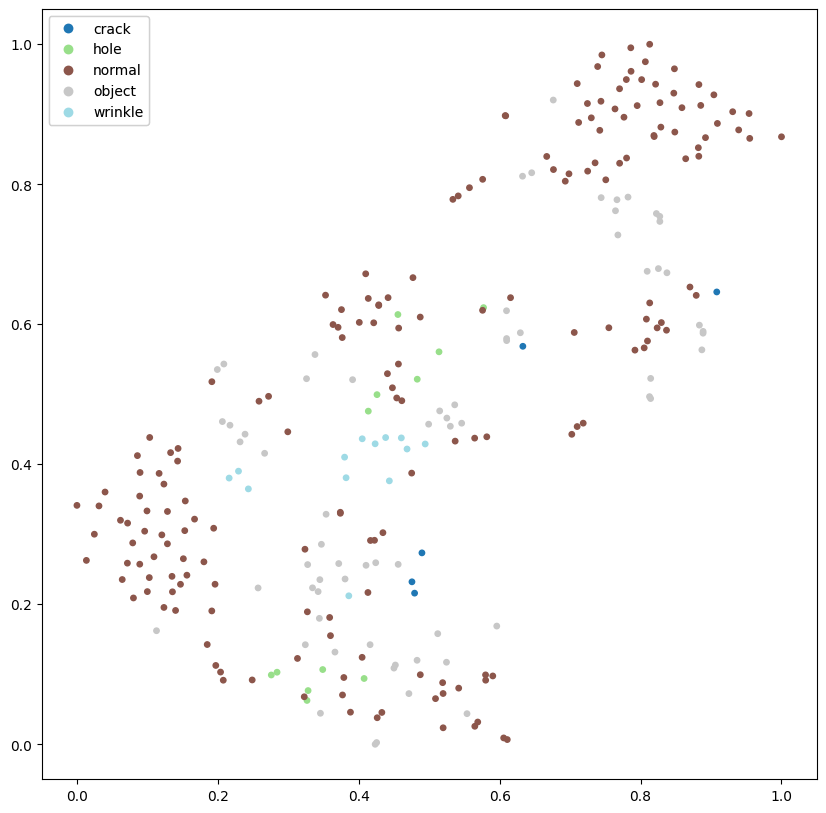

Save features and results to work_dir/tsne_20240612_210147/


: 

In [39]:
print('Running t-SNE.')
for key, val in results.items():
    result = tsne_model.fit_transform(val)
    res_min, res_max = result.min(0), result.max(0)
    res_norm = (result - res_min) / (res_max - res_min)
    _, ax = plt.subplots(figsize=(10, 10))
    scatter = ax.scatter(
        res_norm[:, 0],
        res_norm[:, 1],
        alpha=1.0,
        s=15,
        c=labels,
        cmap='tab20')
    if legend:
        legend = ax.legend(scatter.legend_elements()[0], classes)
        ax.add_artist(legend)
    plt.savefig(f'{tsne_work_dir}{key}.png')
    if show:
        plt.show()
print(f'Save features and results to {tsne_work_dir}')

In [31]:
classes

[0, 1, 2, 3, 4]